In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ozguraslank/brain-stroke-ct-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.41G/1.41G [00:10<00:00, 144MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ozguraslank/brain-stroke-ct-dataset/versions/3


In [10]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split  # ✅ ADD THIS
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


In [7]:
!pip install torch torchvision torchaudio opencv-python matplotlib scikit-learn tqdm kagglehub


In [2]:
!pip install -q tqdm albumentations


In [4]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("ozguraslank/brain-stroke-ct-dataset")
print("Dataset path:", path)

# Dataset base path
BASE_PATH = os.path.join(path, "Brain_Stroke_CT_Dataset")
CATEGORIES = ["Bleeding", "Ischemia"]

print("Base path:", BASE_PATH)
print("Categories:", CATEGORIES)


Dataset path: /root/.cache/kagglehub/datasets/ozguraslank/brain-stroke-ct-dataset/versions/3
Base path: /root/.cache/kagglehub/datasets/ozguraslank/brain-stroke-ct-dataset/versions/3/Brain_Stroke_CT_Dataset
Categories: ['Bleeding', 'Ischemia']


In [5]:
images = []
masks = []

# Collect all PNGs that exist in both PNG and OVERLAY
for cat in CATEGORIES:
    img_dir = os.path.join(BASE_PATH, cat, "PNG")
    mask_dir = os.path.join(BASE_PATH, cat, "OVERLAY")

    img_files = set(os.listdir(img_dir))
    mask_files = set(os.listdir(mask_dir))
    common = sorted(list(img_files & mask_files))

    for fname in common:
        images.append(os.path.join(img_dir, fname))
        masks.append(os.path.join(mask_dir, fname))

print(f"Total paired samples found: {len(images)}")


Total paired samples found: 2223


In [11]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_imgs)}, Validation samples: {len(val_imgs)}")


Training samples: 1778, Validation samples: 445


In [12]:
class StrokeSegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_paths):
        self.img_paths = img_paths
        self.mask_paths = mask_paths

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load CT (grayscale)
        img = cv2.imread(self.img_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (256, 256))

        # Load overlay (as RGB, exact as dataset)
        mask = cv2.imread(self.mask_paths[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (256, 256))

        # Normalize both
        img = img / 255.0
        mask = mask / 255.0

        # Convert to tensors
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)      # (1, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)  # (3, H, W)

        return img, mask


In [13]:
train_dataset = StrokeSegmentationDataset(train_imgs, train_masks)
val_dataset = StrokeSegmentationDataset(val_imgs, val_masks)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print(f"Train batches: {len(train_loader)} | Validation batches: {len(val_loader)}")


Train batches: 445 | Validation batches: 112


In [14]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, padding=0):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.bottleneck = DoubleConv(512, 1024)

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec1 = DoubleConv(1024, 512)

        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec2 = DoubleConv(512, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec4 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        c1 = self.down1(x)
        c2 = self.down2(self.pool(c1))
        c3 = self.down3(self.pool(c2))
        c4 = self.down4(self.pool(c3))

        b = self.bottleneck(self.pool(c4))

        d1 = self.up1(b)
        d1 = torch.cat([d1, c4], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, c3], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, c2], dim=1)
        d3 = self.dec3(d3)

        d4 = self.up4(d3)
        d4 = torch.cat([d4, c1], dim=1)
        d4 = self.dec4(d4)

        return torch.sigmoid(self.final(d4))


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Training on:", device)


Training on: cuda


In [16]:
num_epochs = 35

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = criterion(preds, masks)
            val_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 1/35: 100%|██████████| 445/445 [02:02<00:00,  3.62it/s]


Epoch [1/35] - Train Loss: 0.3515 | Val Loss: 0.2672


Epoch 2/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [2/35] - Train Loss: 0.2257 | Val Loss: 0.2001


Epoch 3/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [3/35] - Train Loss: 0.1889 | Val Loss: 0.1827


Epoch 4/35: 100%|██████████| 445/445 [02:04<00:00,  3.56it/s]


Epoch [4/35] - Train Loss: 0.1742 | Val Loss: 0.1737


Epoch 5/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [5/35] - Train Loss: 0.1673 | Val Loss: 0.1692


Epoch 6/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [6/35] - Train Loss: 0.1636 | Val Loss: 0.1658


Epoch 7/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [7/35] - Train Loss: 0.1616 | Val Loss: 0.1640


Epoch 8/35: 100%|██████████| 445/445 [02:04<00:00,  3.59it/s]


Epoch [8/35] - Train Loss: 0.1601 | Val Loss: 0.1630


Epoch 9/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [9/35] - Train Loss: 0.1591 | Val Loss: 0.1625


Epoch 10/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [10/35] - Train Loss: 0.1585 | Val Loss: 0.1615


Epoch 11/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [11/35] - Train Loss: 0.1580 | Val Loss: 0.1611


Epoch 12/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [12/35] - Train Loss: 0.1576 | Val Loss: 0.1610


Epoch 13/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [13/35] - Train Loss: 0.1573 | Val Loss: 0.1608


Epoch 14/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [14/35] - Train Loss: 0.1572 | Val Loss: 0.1606


Epoch 15/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [15/35] - Train Loss: 0.1568 | Val Loss: 0.1604


Epoch 16/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [16/35] - Train Loss: 0.1568 | Val Loss: 0.1606


Epoch 17/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [17/35] - Train Loss: 0.1567 | Val Loss: 0.1602


Epoch 18/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [18/35] - Train Loss: 0.1566 | Val Loss: 0.1604


Epoch 19/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [19/35] - Train Loss: 0.1565 | Val Loss: 0.1601


Epoch 20/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [20/35] - Train Loss: 0.1565 | Val Loss: 0.1601


Epoch 21/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [21/35] - Train Loss: 0.1564 | Val Loss: 0.1600


Epoch 22/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [22/35] - Train Loss: 0.1563 | Val Loss: 0.1602


Epoch 23/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [23/35] - Train Loss: 0.1563 | Val Loss: 0.1599


Epoch 24/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [24/35] - Train Loss: 0.1562 | Val Loss: 0.1599


Epoch 25/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [25/35] - Train Loss: 0.1563 | Val Loss: 0.1601


Epoch 26/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [26/35] - Train Loss: 0.1561 | Val Loss: 0.1599


Epoch 27/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [27/35] - Train Loss: 0.1561 | Val Loss: 0.1600


Epoch 28/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [28/35] - Train Loss: 0.1561 | Val Loss: 0.1599


Epoch 29/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [29/35] - Train Loss: 0.1560 | Val Loss: 0.1599


Epoch 30/35: 100%|██████████| 445/445 [02:05<00:00,  3.55it/s]


Epoch [30/35] - Train Loss: 0.1561 | Val Loss: 0.1599


Epoch 31/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [31/35] - Train Loss: 0.1560 | Val Loss: 0.1598


Epoch 32/35: 100%|██████████| 445/445 [02:04<00:00,  3.58it/s]


Epoch [32/35] - Train Loss: 0.1560 | Val Loss: 0.1598


Epoch 33/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [33/35] - Train Loss: 0.1560 | Val Loss: 0.1598


Epoch 34/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [34/35] - Train Loss: 0.1560 | Val Loss: 0.1611


Epoch 35/35: 100%|██████████| 445/445 [02:04<00:00,  3.57it/s]


Epoch [35/35] - Train Loss: 0.1559 | Val Loss: 0.1598


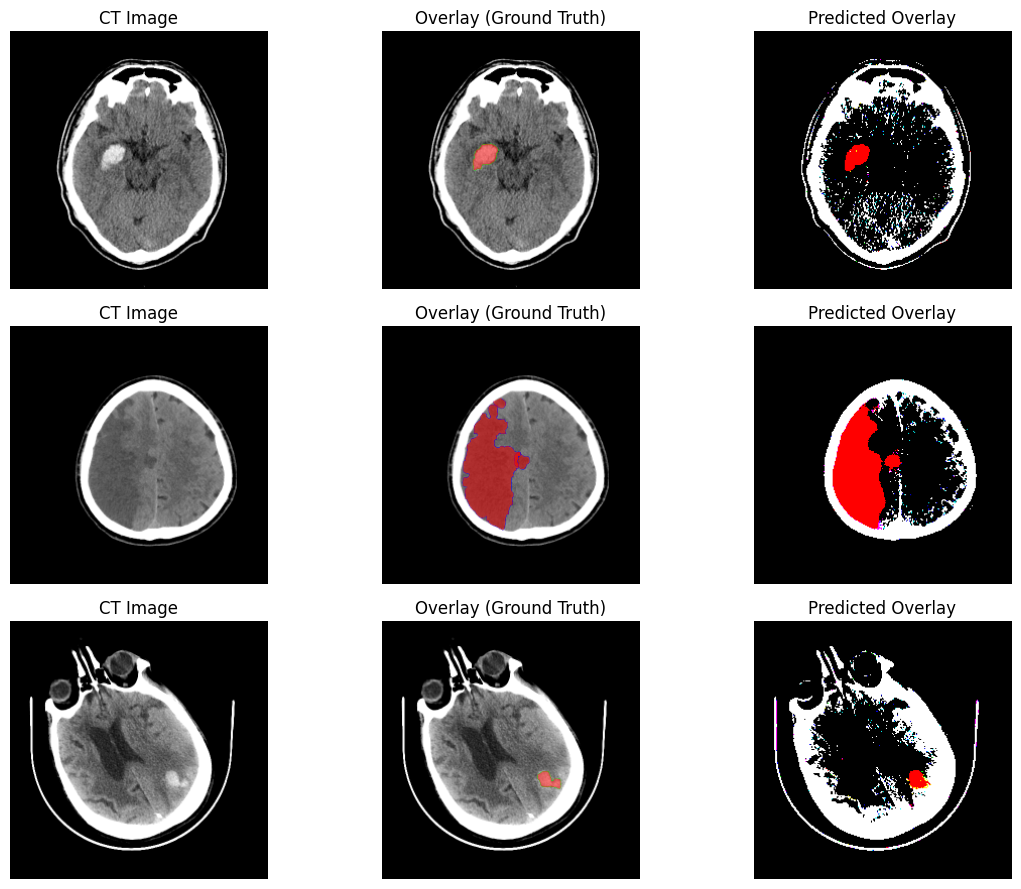

In [19]:

import random
import matplotlib.pyplot as plt
import torch
import numpy as np

model.eval()
with torch.no_grad():
    # Get a random batch from validation loader
    val_iter = iter(val_loader)
    total_batches = len(val_loader)
    random_batch_index = random.randint(0, total_batches - 1)

    for _ in range(random_batch_index):
        imgs, masks = next(val_iter)

    imgs, masks = imgs.to(device), masks.to(device)
    preds = model(imgs)
    preds = (preds > 0.5).float()

# Pick 3 random indices from this batch to visualize
indices = random.sample(range(imgs.size(0)), 3)

plt.figure(figsize=(12, 9))
for i, idx in enumerate(indices):
    img = imgs[idx][0].cpu().numpy()
    mask_true = masks[idx].permute(1, 2, 0).cpu().numpy()
    mask_pred = preds[idx].permute(1, 2, 0).cpu().numpy()

    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(img, cmap='gray')
    plt.title("CT Image")
    plt.axis("off")

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(mask_true, cmap='gray')
    plt.title("Overlay (Ground Truth)")
    plt.axis("off")

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(mask_pred, cmap='gray')
    plt.title("Predicted Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()
